In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pandas.tseries.offsets import BDay
from sklearn.externals import joblib
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error

### Time Series Exploration
Functions for checking stationarity (constant mean, constant variance and autocorrelation that does not depend on time) and for plotting ACF (autocorrelation function) and PACF (partial autocorrelation function)

In [2]:
def test_stationarity(timeseries):
    """Check stationarity of time series by visualizing the rolling mean and standard deviation. 
    Performs Dickey-Fuller Test."""
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=20).mean()
    rolstd = timeseries.rolling(window=20).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    # Notes on Dickey-Fuller Test :
    #Here the null hypothesis is that the TS is non-stationary. 
    #The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. 
    #If the ‘Test Statistic’ < ‘Critical Value’, we can reject the null hypothesis and 
    # say that the series is stationary. 
    from statsmodels.tsa.stattools import adfuller
    
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(timeseries['y'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [3]:
def acf_pcf_plots(timeseries):
    """Generate ACF and PCF plots"""
    
    from statsmodels.tsa.stattools import acf, pacf
    lag_acf = acf(timeseries, nlags=30)
    lag_pacf = pacf(timeseries, nlags=30, method='ols')
    
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

### Time Series Modelling

In [4]:
def create_simple_train_test(df_processed,step):
    """Create train and test set after processing dataframe.
    Take points with fixed interval (step) from beginning to end of dataframe as test set and 
    the remaining as training set."""
    
    # create test set with stepsize 'step' from beginning to end
    df_test = df_processed.iloc[range(0,len(df_processed)+1,step),:]
    
    # set the remaining points as training set
    index = ~(df_processed['ds'].isin(df_test['ds']))
    df_train = df_processed.loc[index]
    
    return df_test, df_train

In [5]:
def fit_prophet_train_test(df_train,df_test,changepoint_range, changepoint_prior_scale):
    """Create a Prophet Model with specified parameters changepoint_range & changepoint_prior_scale.
    Fit the training set and evaluate performance on testing set."""
    
    # create Prophet model
    model = Prophet(changepoint_range=changepoint_range, changepoint_prior_scale=changepoint_prior_scale)
    model.fit(df_train)
    
    # Get test dates 
    test_dates = df_test[['ds']]
    
    # Fit the model to test dates
    predicted = model.predict(test_dates)
    
    plt.figure(figsize=[10,5])
    plt.plot(df_test['ds'], df_test['y'], color='r', label='actual test values')
    plt.plot(predicted['ds'],predicted['yhat'], color='g', label='predicted test values')
    plt.legend(loc='best')
    
    return model,predicted

In [6]:
def get_forecast(model, n_days):
    """Generate forecasts for specified number of days in the future."""
    
    # Make a dataframe with a column ds containing the dates for which a prediction is to be made
    future = model.make_future_dataframe(periods=n_days)
    
    # Filter only for business days (weekdays)
    isBusinessDay = BDay().onOffset
    weekdays = future['ds'].map(isBusinessDay)
    future = future[weekdays]
    
    # Make forecast
    forecast = model.predict(future)
    
    return forecast

In [7]:
def plot_forecasted_cv(df_cv, cutoff_date):
    """Generate plot of actual values vs forecasted values obtained from df_cv. 
    df_cv is dataframe containing prediction results from cross_validation function in Prophet package."""
    
    current_horizon = df_cv[df_cv['cutoff']==cutoff_date]
    plt.plot(current_horizon['ds'], current_horizon['y'], color='r', label='actual values')
    plt.plot(current_horizon['ds'], current_horizon['yhat'], color='g', label='forecasted values')
    plt.legend(loc='best')

In [8]:
def plot_cross_validation_metric(df_cv, metric, rolling_window=0.1, ax=None):
    """Plot a performance metric vs. forecast horizon from cross validation.
    Cross validation produces a collection of out-of-sample model predictions
    that can be compared to actual values, at a range of different horizons
    (distance from the cutoff). This computes a specified performance metric
    for each prediction, and aggregated over a rolling window with horizon.
    This uses fbprophet.diagnostics.performance_metrics to compute the metrics.
    Valid values of metric are 'mse', 'rmse', 'mae', 'mape', and 'coverage'.
    rolling_window is the proportion of data included in the rolling window of
    aggregation. The default value of 0.1 means 10% of data are included in the
    aggregation for computing the metric.
    As a concrete example, if metric='mse', then this plot will show the
    squared error for each cross validation prediction, along with the MSE
    averaged over rolling windows of 10% of the data.
    Parameters
    ----------
    df_cv: The output from fbprophet.diagnostics.cross_validation.
    metric: Metric name, one of ['mse', 'rmse', 'mae', 'mape', 'coverage'].
    rolling_window: Proportion of data to use for rolling average of metric.
        In [0, 1]. Defaults to 0.1.
    ax: Optional matplotlib axis on which to plot. If not given, a new figure
        will be created.
    Returns
    -------
    a matplotlib figure.
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=(10, 6))
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    # Get the metric at the level of individual predictions, and with the rolling window.
    df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=0)
    df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)

    # Some work because matplotlib does not handle timedelta
    # Target ~10 ticks.
    tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.
    # Find the largest time resolution that has <1 unit per bin.
    dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
    dt_names = [
        'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
        'nanoseconds'
    ]
    dt_conversions = [
        24 * 60 * 60 * 10 ** 9,
        60 * 60 * 10 ** 9,
        60 * 10 ** 9,
        10 ** 9,
        10 ** 6,
        10 ** 3,
        1.,
    ]
    for i, dt in enumerate(dts):
        if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
            break

    x_plt = df_none['horizon'].astype(np.int64) / float(dt_conversions[i])
    x_plt_h = df_h['horizon'].astype(np.int64) / float(dt_conversions[i])

    ax.plot(x_plt, df_none[metric], '.', alpha=0.5, c='gray')
    ax.plot(x_plt_h, df_h[metric], '-', c='b')
    ax.grid(True)

    ax.set_xlabel('Horizon ({})'.format(dt_names[i]))
    ax.set_ylabel(metric)
    return fig

## Forecasting S&P Global 1200 Industrials Index

In [ ]:
df_snp_indu = pd.read_excel('S&P Global 1200 Industrials (SGN).xls')
# Pick relevant column
df_snp_indu= df_snp_indu[['Effective date ','S&P GLOBAL 1200 - Industrials  (Sector )']]
# Renaming column (required for passing to Prophet)
df_snp_indu.columns = ['ds','y']

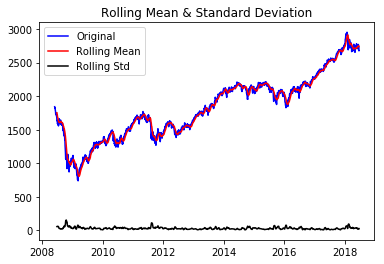

C:\Users\godeliva.marisu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Results of Augmented Dickey-Fuller test:
test statistic            -0.210526
p-value                    0.937255
# of lags                 18.000000
# of observations       2598.000000
Critical Value (1%)       -3.432870
Critical Value (5%)       -2.862653
Critical Value (10%)      -2.567363
dtype: float64


In [10]:
test_stationarity(df_snp_indu.set_index('ds'))

Since t-stats is greater than the critical values, we do not reject Ho. Thus the series is non stationary.

In [11]:
df_test_snp_indu,df_train_snp_indu = create_simple_train_test(df_snp_indu,10)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\godeliva.marisu\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


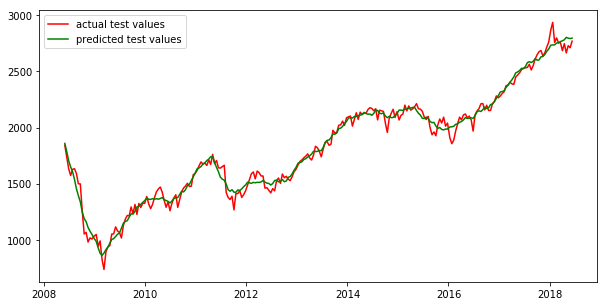

In [12]:
snp_indu_model, snp_indu_predicted = fit_prophet_train_test(df_train_snp_indu,df_test_snp_indu,0.9, 0.1)

By taking steps of 10 for the test set and setting the remaining points as training set, the model can predict trends in the test set well but not capturing fluctuations really well.

In [13]:
# Save Prophet model
model_SNP_indu= Prophet(changepoint_range=0.9, changepoint_prior_scale= 0.1)
joblib.dump(model_SNP_indu, 'SNP_Indu_Model.pkl') 

['SNP_Indu_Model.pkl']

In [13]:
print('MSE: ',mean_squared_error(df_test_snp_indu['y'],snp_indu_predicted['yhat']))

MSE:  3167.1644344314736


In [14]:
print('MAE: ',mean_absolute_error(df_test_snp_indu['y'],snp_indu_predicted['yhat']))

MAE:  43.30289113523696


### Getting Forecasts

In [15]:
forecast_snp_indu = get_forecast(snp_indu_model,365)
forecast_snp_indu[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2715,2019-06-16,3025.610069,2488.642661,3498.369300
2716,2019-06-17,3055.541115,2528.434227,3539.301719
2717,2019-06-18,3054.979100,2517.757246,3549.117333
2718,2019-06-19,3053.667940,2506.404111,3563.411086
2719,2019-06-20,3053.711608,2505.380853,3518.978142


In [17]:
#forecast_snp_indu.to_csv('S&P Global 1200 Industrials Forecast.csv', index=False)

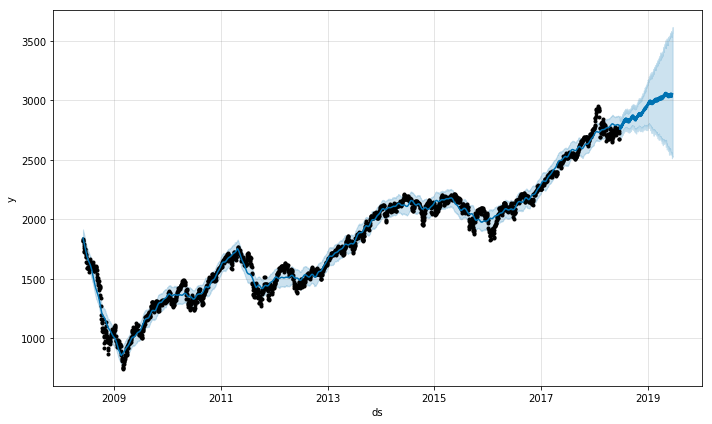

In [16]:
fig_snp_indu =snp_indu_model.plot(forecast_snp_indu)

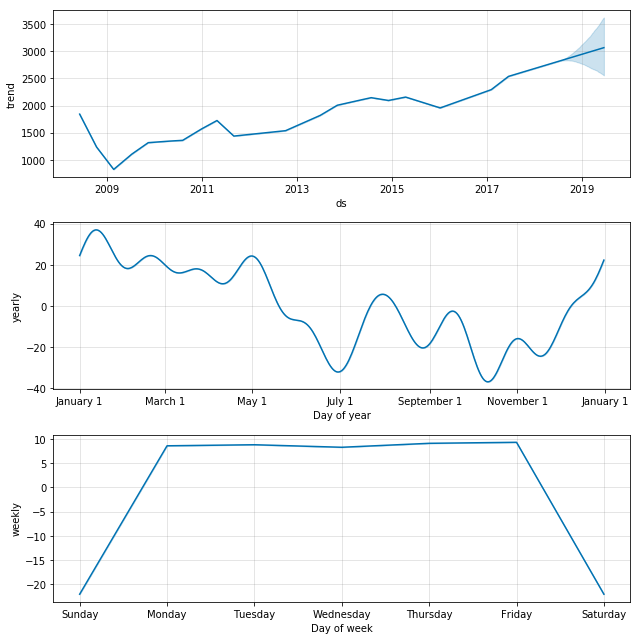

In [17]:
snp_indu_components = snp_indu_model.plot_components(forecast_snp_indu)

### Cross-Validation with Multiple Cut-Off Points
Cross validation to measure forecast error using historical data. 
This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. Then compare the forecasted values to the actual values. 

In [18]:
df_cv_snp_indu = cross_validation(snp_indu_model,period ='90 days',horizon = '90 days')

INFO:fbprophet.diagnostics:Making 37 forecasts with cutoffs between 2009-05-08 00:00:00 and 2018-03-22 00:00:00
C:\Users\godeliva.marisu\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


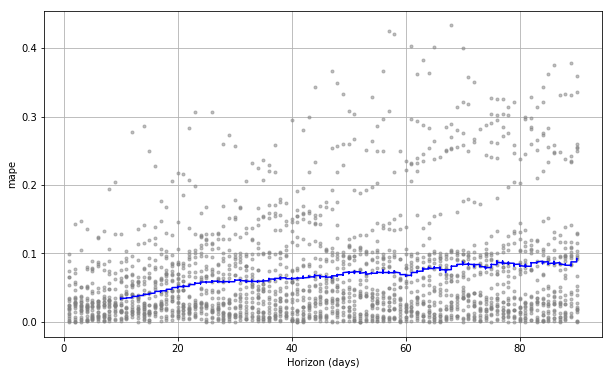

In [19]:
df_p_snp_ind = performance_metrics(df_cv_snp_indu)
fig_cv_snp_indu = plot_cross_validation_metric(df_cv_snp_indu, metric='mape')

MAPE (Mean absolute percentage error) of around 3% are typical for 10 days horizon and 9% for 90 days horizon

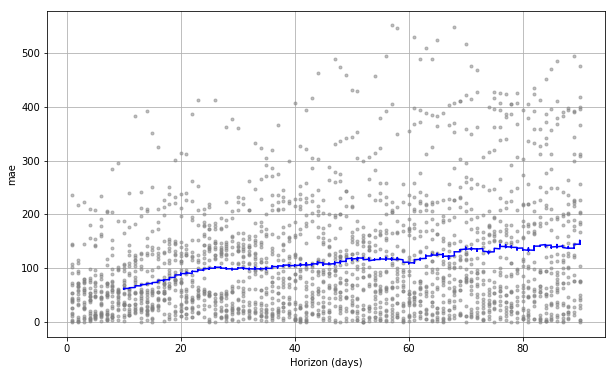

In [20]:
fig_cv_snp_indu_2 = plot_cross_validation_metric(df_cv_snp_indu, metric='mae')

MAE (mean absolute error) of 62 are typical for 10 days horizon, increasing up to 151 for 90 days horizon.

In [21]:
df_p_snp_ind.head()

,horizon,mse,rmse,mae,mape,coverage
1910,10 days,7101.047729,84.267715,62.136414,0.034172,0.643192
1045,10 days,7122.498017,84.394893,62.390479,0.034273,0.638498
756,10 days,7120.281157,84.381758,62.362942,0.034292,0.638498
236,10 days,7125.476507,84.412538,62.387863,0.034339,0.638498
409,10 days,6882.114027,82.958508,61.572011,0.034096,0.638498


In [22]:
df_p_snp_ind.tail()

,horizon,mse,rmse,mae,mape,coverage
1383,90 days,39804.207484,199.509918,149.630148,0.091261,0.525822
518,90 days,39785.197394,199.462271,149.522604,0.091139,0.525822
576,90 days,40406.729804,201.014253,151.023391,0.092237,0.521127
1730,90 days,39875.082969,199.687463,150.181699,0.091567,0.521127
2134,90 days,40308.903345,200.770773,151.393695,0.092017,0.516432


## Forecasting S&P Global 1200 Consumer Staples Index

In [14]:
df_snp_cs = pd.read_excel('S&P Global 1200 Consumer Staples (SGCS).xls')
# Pick relevant column
df_snp_cs= df_snp_cs[['Effective date ','S&P GLOBAL 1200 - Consumer Staples  (Sector )']]
# Renaming column (required for passing to Prophet)
df_snp_cs.columns = ['ds','y']

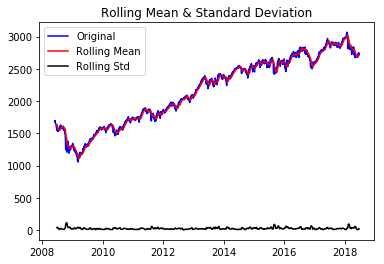

Results of Augmented Dickey-Fuller test:
test statistic            -0.681804
p-value                    0.851407
# of lags                  2.000000
# of observations       2614.000000
Critical Value (1%)       -3.432854
Critical Value (5%)       -2.862646
Critical Value (10%)      -2.567359
dtype: float64


In [15]:
test_stationarity(df_snp_cs.set_index('ds'))

Since t-stats is greater than the critical values, we do not reject Ho. Thus the series is non stationary.

In [16]:
df_test_snp_cs,df_train_snp_cs = create_simple_train_test(df_snp_cs,10)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\godeliva.marisu\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


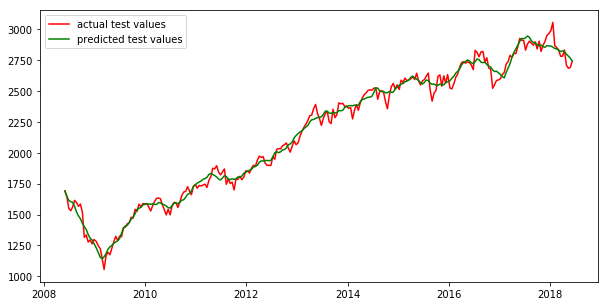

In [17]:
snp_cs_model, snp_cs_predicted = fit_prophet_train_test(df_train_snp_cs,df_test_snp_cs,0.9, 0.3)

By taking steps of 10 for the test set and setting the remaining points as training set, the model can predict trends in the test set well but not capturing sharp fluctuations within short intervals.

In [18]:
# Save Prophet model
model_SNP_CS= Prophet(changepoint_range=0.9, changepoint_prior_scale= 0.3)
joblib.dump(model_SNP_CS, 'SNP_CS_Model.pkl') 

['SNP_CS_Model.pkl']

In [22]:
print('MSE: ',mean_squared_error(df_test_snp_cs['y'],snp_cs_predicted['yhat']))

MSE:  2474.093162370419


In [23]:
print('MAE: ',mean_absolute_error(df_test_snp_cs['y'],snp_cs_predicted['yhat']))

MAE:  38.67953419072013


### Getting Forecasts

In [24]:
forecast_snp_cs = get_forecast(snp_cs_model,365)
forecast_snp_cs[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2715,2019-06-16,2514.275319,1968.257267,3105.748518
2716,2019-06-17,2538.361121,1970.018981,3113.857232
2717,2019-06-18,2538.512002,1989.570401,3118.601644
2718,2019-06-19,2535.746805,1968.738087,3137.115330
2719,2019-06-20,2535.182464,1977.177895,3121.391017


In [25]:
#forecast_snp_cs.to_csv('S&P Global 1200 Consumer Services Forecast.csv', index=False)

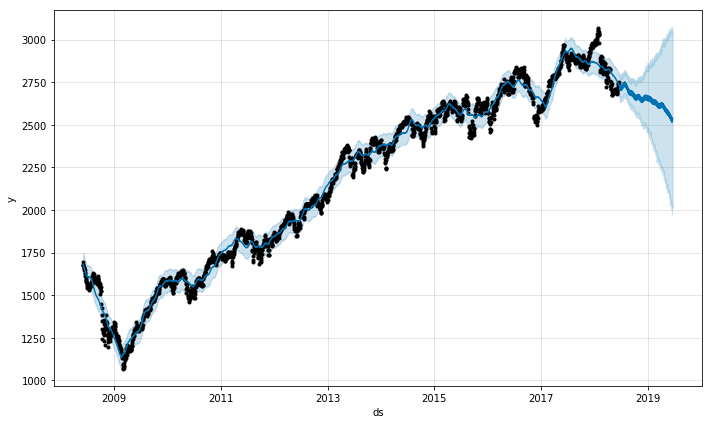

In [53]:
fig_snp_cs =snp_cs_model.plot(forecast_snp_cs)

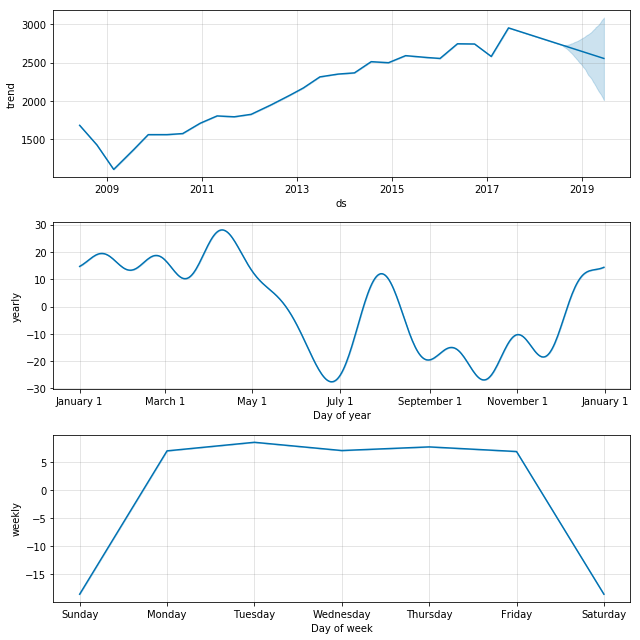

In [54]:
snp_cs_components = snp_cs_model.plot_components(forecast_snp_cs)

### Cross-Validation with Multiple Cut-Off Points
Cross validation to measure forecast error using historical data. 
This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. Then compare the forecasted values to the actual values. 

In [55]:
df_cv_snp_cs = cross_validation(snp_cs_model,period ='90 days',horizon = '90 days')

INFO:fbprophet.diagnostics:Making 37 forecasts with cutoffs between 2009-05-08 00:00:00 and 2018-03-22 00:00:00
C:\Users\godeliva.marisu\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


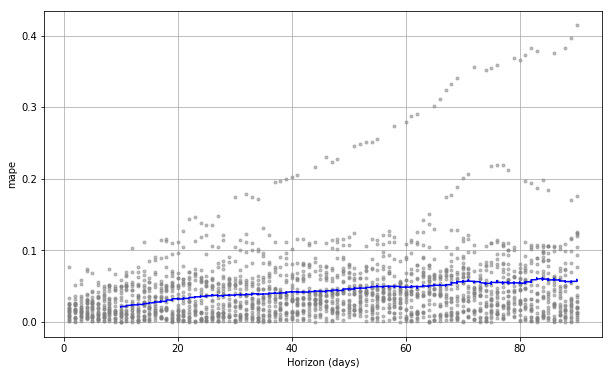

In [56]:
df_p_snp_cs= performance_metrics(df_cv_snp_cs)
fig_cv_snp_cs = plot_cross_validation_metric(df_cv_snp_cs, metric='mape')

MAPE (Mean absolute percentage error) of around 2% are typical for 10 days horizon and 5% for 90 days horizon

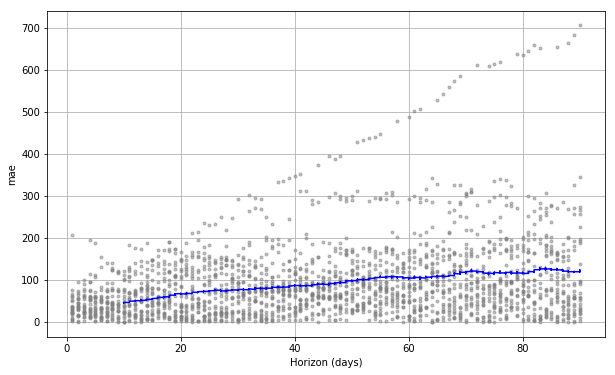

In [57]:
fig_cv_snp_cs_2 = plot_cross_validation_metric(df_cv_snp_cs, metric='mae')

MAE (mean absolute error) of 46 are typical for 10 days horizon, increasing up to 120 for 90 days horizon.

In [61]:
df_p_snp_cs.head()

,horizon,mse,rmse,mae,mape,coverage
1910,10 days,3382.188287,58.156584,45.643698,0.021087,0.497653
1045,10 days,3446.753533,58.709058,46.082774,0.021234,0.497653
756,10 days,3444.249032,58.687725,45.975676,0.021192,0.497653
236,10 days,3468.097297,58.890554,46.187736,0.021347,0.497653
409,10 days,3267.154281,57.159026,45.284879,0.021030,0.502347


In [62]:
df_p_snp_cs.tail()

,horizon,mse,rmse,mae,mape,coverage
1383,90 days,31756.924637,178.204727,121.439495,0.058426,0.657277
518,90 days,31972.663818,178.809015,122.155000,0.058782,0.657277
576,90 days,31906.000190,178.622508,121.704691,0.058624,0.661972
1730,90 days,29963.713947,173.100300,118.778321,0.056909,0.666667
2134,90 days,30249.602918,173.924130,119.646624,0.057234,0.661972


## Forecasting S&P Global 1200 Consumer Discretionary Index

In [19]:
df_snp_cd = pd.read_excel('S&P Global 1200 Consumer Discretionary (SGD).xls')
# Pick relevant column
df_snp_cd= df_snp_cd[['Effective date ','S&P GLOBAL 1200 - Consumer Discretionary  (Sector )']]
# Renaming column (required for passing to Prophet)
df_snp_cd.columns = ['ds','y']

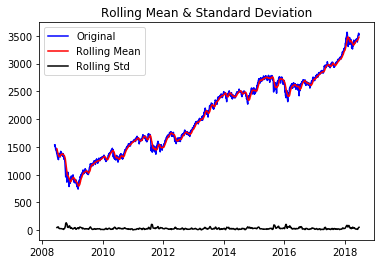

Results of Augmented Dickey-Fuller test:
test statistic             0.510529
p-value                    0.985190
# of lags                  2.000000
# of observations       2614.000000
Critical Value (1%)       -3.432854
Critical Value (5%)       -2.862646
Critical Value (10%)      -2.567359
dtype: float64


In [20]:
test_stationarity(df_snp_cd.set_index('ds'))

Since t-stats is greater than the critical values, we do not reject Ho. Thus the series is non stationary.

In [21]:
df_test_snp_cd,df_train_snp_cd = create_simple_train_test(df_snp_cd,10)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\godeliva.marisu\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


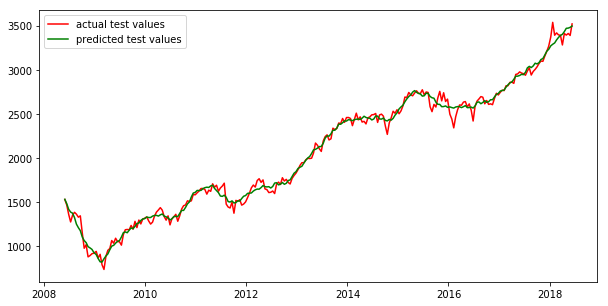

In [22]:
snp_cd_model, snp_cd_predicted = fit_prophet_train_test(df_train_snp_cd,df_test_snp_cd,0.9, 0.5)

In [23]:
# Save Prophet model
model_SNP_CD= Prophet(changepoint_range=0.9, changepoint_prior_scale= 0.5)
joblib.dump(model_SNP_CD, 'SNP_CD_Model.pkl') 

['SNP_CD_Model.pkl']

In [30]:
print('MSE: ',mean_squared_error(df_test_snp_cd['y'],snp_cd_predicted['yhat']))

MSE:  3474.8573790716277


In [31]:
print('MAE: ',mean_absolute_error(df_test_snp_cd['y'],snp_cd_predicted['yhat']))

MAE:  44.27183879355114


### Getting Forecasts

In [32]:
forecast_snp_cd = get_forecast(snp_cd_model,365)
forecast_snp_cd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2715,2019-06-16,4044.164989,3471.769270,4620.539706
2716,2019-06-17,4043.438394,3475.854237,4611.250816
2717,2019-06-18,4042.154919,3472.775408,4623.337980
2718,2019-06-19,4042.241938,3485.020658,4592.490694
2719,2019-06-20,4042.331922,3468.592961,4635.393101


In [34]:
#forecast_snp_cd.to_csv('S&P Global 1200 Consumer Discretionary.csv', index=False)

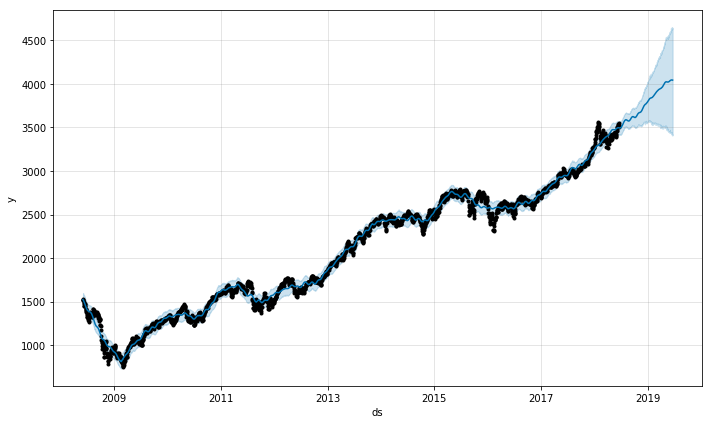

In [83]:
fig_snp_cd =snp_cd_model.plot(forecast_snp_cd)

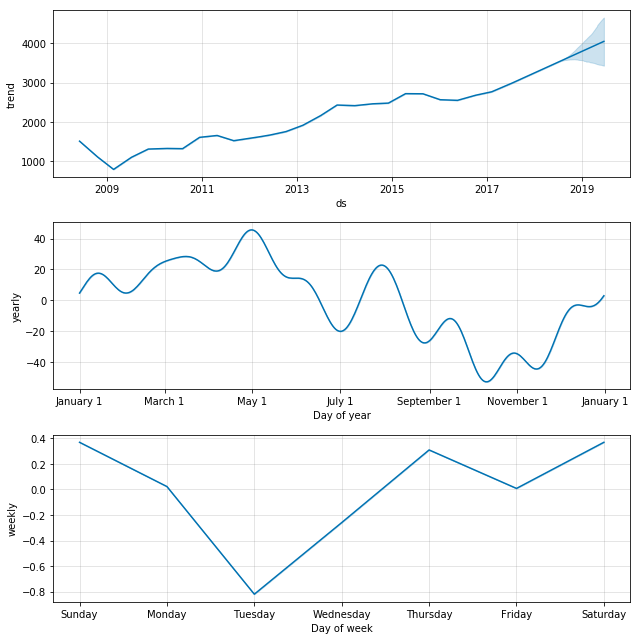

In [84]:
snp_cd_components = snp_cd_model.plot_components(forecast_snp_cd)

### Cross-Validation with Multiple Cut-Off Points
Cross validation to measure forecast error using historical data. 
This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. Then compare the forecasted values to the actual values. 

In [85]:
df_cv_snp_cd = cross_validation(snp_cd_model,period ='90 days',horizon = '90 days')

INFO:fbprophet.diagnostics:Making 37 forecasts with cutoffs between 2009-05-08 00:00:00 and 2018-03-22 00:00:00
C:\Users\godeliva.marisu\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


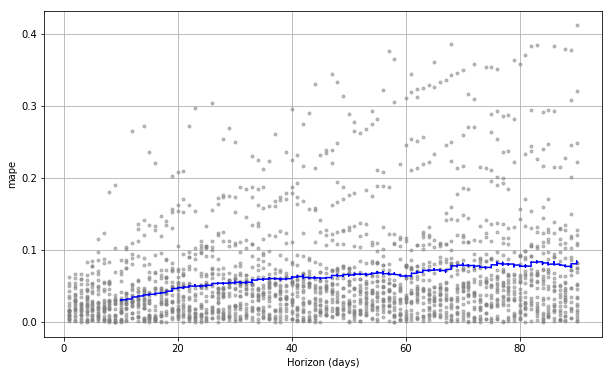

In [86]:
df_p_snp_cd= performance_metrics(df_cv_snp_cd)
fig_cv_snp_cd = plot_cross_validation_metric(df_cv_snp_cd, metric='mape')

MAPE (Mean absolute percentage error) of around 3% are typical for 10 days horizon and 8% for 90 days horizon

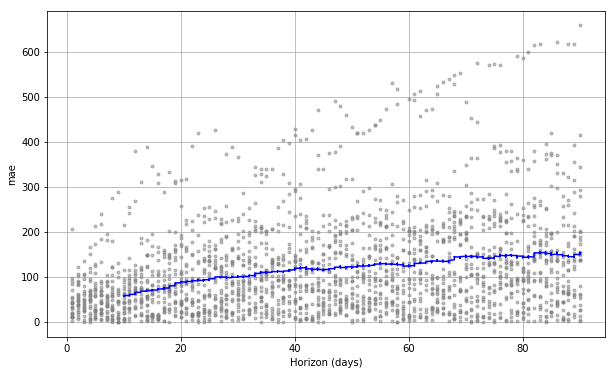

In [87]:
fig_cv_snp_cd_2 = plot_cross_validation_metric(df_cv_snp_cd, metric='mae')

MAE (mean absolute error) of 58 are typical for 10 days horizon, increasing up to 153 for 90 days horizon.

In [92]:
df_p_snp_cd.head()

,horizon,mse,rmse,mae,mape,coverage
1910,10 days,5927.478714,76.990121,57.961671,0.030032,0.516432
1045,10 days,5952.929458,77.155230,58.259400,0.030135,0.511737
756,10 days,5946.588496,77.114126,58.156856,0.030119,0.511737
236,10 days,5915.373291,76.911464,57.856179,0.029953,0.516432
409,10 days,5719.947037,75.630331,57.029075,0.029744,0.521127


In [93]:
df_p_snp_cd.tail()

,horizon,mse,rmse,mae,mape,coverage
1383,90 days,41101.038394,202.733910,153.267527,0.083502,0.572770
518,90 days,41153.741044,202.863849,153.499745,0.083574,0.572770
576,90 days,41701.118729,204.208518,154.890040,0.084528,0.568075
1730,90 days,40194.252477,200.485043,153.006763,0.083143,0.568075
2134,90 days,40210.844592,200.526419,153.271766,0.083218,0.568075


## Forecasting S&P Global 1200 Information Technology Index

In [24]:
df_snp_tech = pd.read_excel('S&P Global 1200 IT (SGI).xls')
# Pick relevant column
df_snp_tech= df_snp_tech[['Effective date ','S&P GLOBAL 1200 - Information Technology  (Sector )']]
# Renaming column (required for passing to Prophet)
df_snp_tech.columns = ['ds','y']

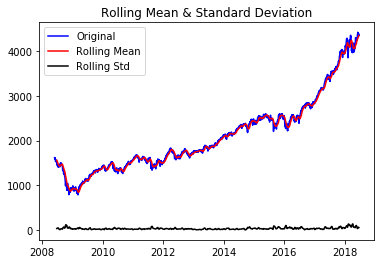

Results of Augmented Dickey-Fuller test:
test statistic             2.367393
p-value                    0.998994
# of lags                 12.000000
# of observations       2604.000000
Critical Value (1%)       -3.432864
Critical Value (5%)       -2.862651
Critical Value (10%)      -2.567361
dtype: float64


In [25]:
test_stationarity(df_snp_tech.set_index('ds'))

Since t-stats is far greater than the critical values, we do not reject Ho. Thus the series is non stationary.

In [26]:
df_test_snp_tech,df_train_snp_tech = create_simple_train_test(df_snp_tech,10)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\godeliva.marisu\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


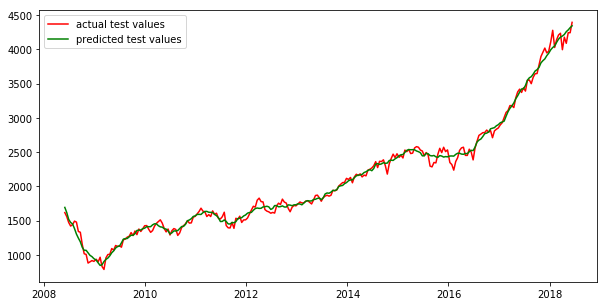

In [27]:
snp_tech_model, snp_tech_predicted = fit_prophet_train_test(df_train_snp_tech,df_test_snp_tech,0.9, 0.3)

In [31]:
# Save Prophet model
model_SNP_tech= Prophet(changepoint_range=0.9, changepoint_prior_scale= 0.3)
joblib.dump(model_SNP_tech, 'SNP_Tech_Model.pkl') 

['SNP_Tech_Model.pkl']

In [39]:
print('MSE: ',mean_squared_error(df_test_snp_tech['y'],snp_tech_predicted['yhat']))
print('MAE: ',mean_absolute_error(df_test_snp_tech['y'],snp_tech_predicted['yhat']))

MSE:  4203.511239578857
MAE:  49.68730181706829


### Getting Forecasts

In [40]:
forecast_snp_tech = get_forecast(snp_tech_model,365)
forecast_snp_tech[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2715,2019-06-16,5201.541605,4485.015455,5753.280317
2716,2019-06-17,5258.050144,4525.890714,5849.033656
2717,2019-06-18,5258.377999,4504.864615,5871.561184
2718,2019-06-19,5258.472758,4527.790257,5863.773425
2719,2019-06-20,5257.673685,4514.167856,5841.962863


In [42]:
#forecast_snp_tech.to_csv('S&P Global 1200 Technology Forecast.csv', index=False)

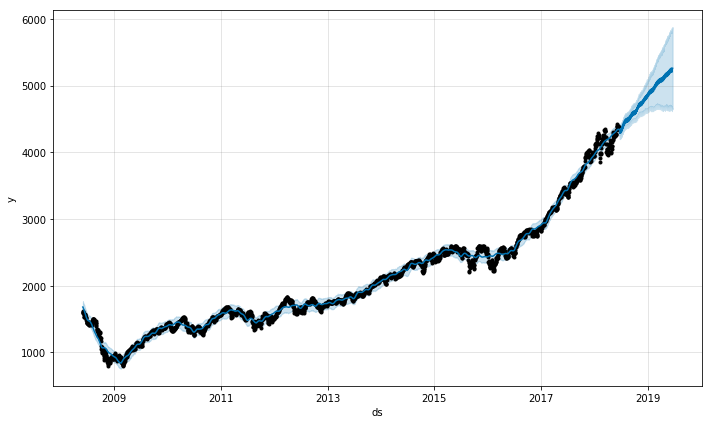

In [125]:
fig_snp_tech =snp_tech_model.plot(forecast_snp_tech)

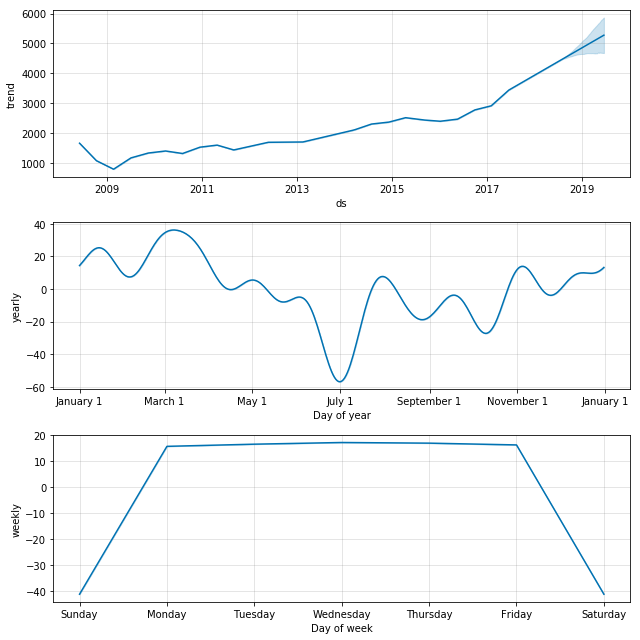

In [126]:
snp_tech_components = snp_tech_model.plot_components(forecast_snp_tech)

### Cross-Validation with Multiple Cut-Off Points
Cross validation to measure forecast error using historical data. 
This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. Then compare the forecasted values to the actual values. 

In [127]:
df_cv_snp_tech = cross_validation(snp_tech_model,period ='90 days',horizon = '90 days')

INFO:fbprophet.diagnostics:Making 37 forecasts with cutoffs between 2009-05-08 00:00:00 and 2018-03-22 00:00:00
C:\Users\godeliva.marisu\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


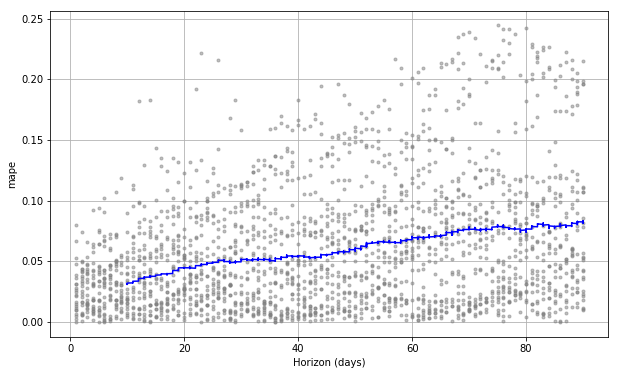

In [128]:
df_p_snp_tech= performance_metrics(df_cv_snp_tech)
fig_cv_snp_tech = plot_cross_validation_metric(df_cv_snp_tech, metric='mape')

MAPE (Mean absolute percentage error) of around 3% are typical for 10 days horizon and 8% for 90 days horizon

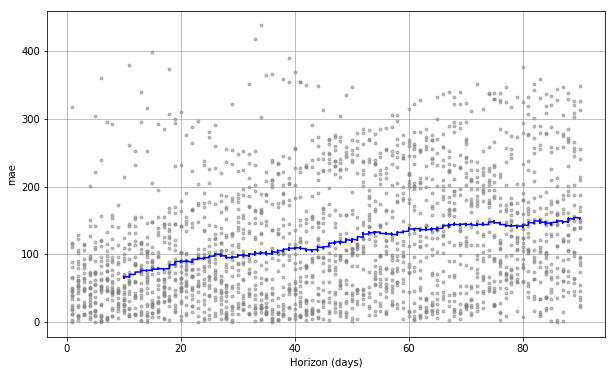

In [129]:
fig_cv_snp_tech_2 = plot_cross_validation_metric(df_cv_snp_tech, metric='mae')

MAE (mean absolute error) of 67 are typical for 10 days horizon, increasing up to 153 for 90 days horizon.

In [130]:
df_p_snp_tech.head()

,horizon,mse,rmse,mae,mape,coverage
1910,10 days,7761.325561,88.098386,66.735804,0.031497,0.436620
1045,10 days,7765.704148,88.123233,66.780052,0.031455,0.436620
756,10 days,7748.950033,88.028121,66.596244,0.031403,0.441315
236,10 days,7697.416249,87.734920,66.285358,0.031251,0.441315
409,10 days,7242.880879,85.105117,65.110009,0.031068,0.441315


In [131]:
df_p_snp_tech.tail()

,horizon,mse,rmse,mae,mape,coverage
1383,90 days,32394.223951,179.983955,152.280129,0.081829,0.553991
518,90 days,32474.956527,180.208092,152.571195,0.081964,0.553991
576,90 days,32508.216169,180.300350,152.679679,0.082181,0.558685
1730,90 days,32447.034320,180.130604,152.585016,0.081742,0.558685
2134,90 days,32593.090341,180.535565,153.165349,0.081862,0.553991
